# Siren 알아보기
GitHub: [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
import os
from collections import OrderedDict

def get_mgrid(sidelen:int, dim:int=2):
    '''[-1, 1] 구간 평탄화된 그리드(x,y,...)좌표 생성.'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [ ]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input):
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate

In [ ]:
class Siren(nn.Module):
    def __init__(self, in_features:int, hidden_features:int, hidden_layers:int, out_features:int,
                 outermost_linear:bool=False, first_omega_0:float = 30., hidden_omega_0:float = 30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))
        
        for _ in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))
        
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                             np.sqrt(6 / hidden_features) / hidden_omega_0)
            
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()
        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)
                if retain_grad:
                    x.retain_grad()
            
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


In [ ]:
# Differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    
    return div

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

In [ ]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    img =transform(img)
    
    return img

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        return self.coords, self.pixels


In [ ]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)

img_siren.to(device=device)

In [ ]:
total_steps = 500
steps_till_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth) ** 2).mean()

    if not step % steps_till_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)
        
        fig, axes = plt.subplots(1, 3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()
    
    optim.zero_grad()
    loss.backward()
    optim.step()


In [1]:
from siren.dataio import ImageGeneralizationWrapper, CelebA, Implicit2DWrapper
import torch
import numpy as np

In [7]:
img_dataset = CelebA(split='train', downsampled=True)

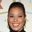

In [8]:
img_dataset[203]

In [9]:
coord_dataset = Implicit2DWrapper(img_dataset, sidelength=(32, 32))

In [10]:
coord_dataset[0], coord_dataset[0][0]['coords'].shape, coord_dataset[0][1]['img'].shape

(({'idx': 0,
   'coords': tensor([[-1.0000, -1.0000],
           [-1.0000, -0.9355],
           [-1.0000, -0.8710],
           ...,
           [ 1.0000,  0.8710],
           [ 1.0000,  0.9355],
           [ 1.0000,  1.0000]])},
  {'img': tensor([[ 1.0000,  0.8431,  0.5529],
           [ 0.9922,  0.8431,  0.5451],
           [ 0.9922,  0.8431,  0.5451],
           ...,
           [ 0.1843, -0.2314, -0.4118],
           [ 0.4902,  0.0510, -0.2235],
           [ 0.3804, -0.0275, -0.2471]])}),
 torch.Size([1024, 2]),
 torch.Size([1024, 3]))

In [11]:
spatial_img, img, gt_dict = coord_dataset.get_item_small(0)
spatial_img.shape

torch.Size([3, 32, 32])

In [12]:
num_context = int(torch.empty(1).uniform_(323 * 323 * 0.2, 323 * 323 * 0.8).item())
sidelength = (323, 323)
print(num_context / np.prod(sidelength))

s = spatial_img.new_empty(1, 323, 323).bernoulli_(p=num_context / np.prod(sidelength))
ss = s.sum()
ss, ss / 323 / 323, s.numel()


0.39225910341324083


(tensor(40743.), tensor(0.3905), 104329)

In [14]:
generalization_dataset = ImageGeneralizationWrapper(coord_dataset,
                                                    train_sparsity_range=[10, 200],
                                                    generalization_mode='cnp')
generalization_dataset[0][0].keys(),generalization_dataset[0][1].keys(),

(dict_keys(['idx', 'coords', 'img_sub', 'coords_sub', 'ctxt_mask']),
 dict_keys(['img']))

In [21]:
generalization_dataset[0][0]['img_sub'].shape

torch.Size([200, 3])

In [22]:
for i in range(10):
    print(generalization_dataset[i][0]['ctxt_mask'].sum())

tensor(189.)
tensor(147.)
tensor(197.)
tensor(35.)
tensor(123.)
tensor(162.)
tensor(173.)
tensor(149.)
tensor(59.)
tensor(105.)


In [23]:
img_sparse = generalization_dataset[0][0]['img_sub']
import matplotlib.pyplot as plt
print(img_sparse.shape)
img_sparse = img_sparse.permute(1,2,0).numpy()
plt.imshow(img_sparse)

torch.Size([200, 3])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


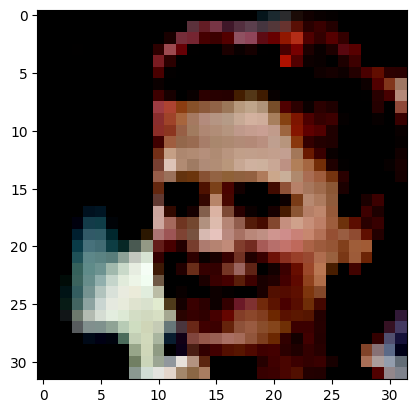

In [26]:
img = generalization_dataset[1][1]['img']
img = img.reshape(32, 32, 3).numpy()
plt.imshow(img)

In [17]:
from skimage.metrics import structural_similarity

In [29]:
img1 = generalization_dataset[1][1]['img'].reshape(32, 32, 3).numpy()
img2 = generalization_dataset[2][1]['img'].reshape(32, 32, 3).numpy()
img1.shape, img2.shape

((32, 32, 3), (32, 32, 3))

In [43]:
structural_similarity(img1, img2, win_size=7, data_range=1., channel_axis=-1)

0.046891112

18.333333333333332